### INITIALIZE:

In [575]:
from __future__ import division
import math
import pandas as pd
from sympy import Symbol
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True,precision=3)
import copy
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize']=(10,10)

%matplotlib inline

---

### EXAMPLE DATA: 

In [89]:
data = pd.DataFrame(index = [1,2,3])
data['x1']=['x1_1','x1_2','x1_3']
data['x2']=['x2_1','x2_2','x2_3']
data['x3']=['x3_1','x3_2','x3_3']
data[Symbol('y')]=[Symbol('y1'),Symbol('y2'),Symbol('y3')]
data

,x1,x2,x3,y
1,x1_1,x2_1,x3_1,y1
2,x1_2,x2_2,x3_2,y2
3,x1_3,x2_3,x3_3,y3


<b>
* The data has three x-features.
* The combined value of each feature multiplied by its Beta coefficient explains the outcome-feature y.      
* From the given values, we derive Beta coefficients for each input-variable that will have the lowest error in explaining the most y_values when given the x_values. 
* For each row, (Beta_1 \* Variable_1) + (Beta_2 \* Variable_2) + (Beta_3 \* Variable_3) must be as close to the y-variable as possible. 
* This set of Betas explains the most of the results and can be used to make predictions on future data.

---

### LARS SUMMARY:
<b>The LARS (Least Angle Regression) algorithm is a penalized regression method that tackles the above problem. It uses the principles of linear regression, but diminishes (penalizes) the coefficients of the x-features whose values are least correlated to the target y-feature. Because the weight of these outliers is penalized, the linear equation becomes less sensitive to extreme values, and is less likely to be skewed by them. The least important features end up as zeroes. This increases the sparsity of the data and is a method of feature selection. 

---

### IMPLEMENTATION GENERAL FLOW:

<b>
1_Prepare the Assets   
* Input Data
* Preprocess data (if needed)
* Split the data (if needed)
* Load the data
    + Input_data: the x-variable data
    + Output target data: the y-variable
  
</b>

<b>
2_Provide the following objects:
* Step_numb: how many steps to take
* Increment: By how much to move the best beta at each step)
* Length and Number of columns in the training variables set
* Initialize a matrix to store every iteration of Beta coefficient values 
* Initialize a list of Beta coefficients. Start them all at 0.
</b>

<b>
3_Iterate through each step (step-wise pattern is used: a bunch of steps happen, and something happens in each step.) 
* Start the step.


</b>	
    
<b>
4_Select the current-best column in the x-data
* Find the residual(error) of each row.
* Calculate each column’s correlation to the residuals.
* Calculate which column reduces the error the most (lowest correlation to residuals).
</b>

<b>
5_Increment the current-best column’s Beta value
</b>

<b>
6_Add the resulting Beta coefficients to the storage list at the top of the step
</b>

<b>
7_Add the entire storage list to the storage matrix at the top of the function 
</b>

<b>
8_End Step and loop to next step
</b>

<b>
9_Evaluate the best list of Beta coefficients from the storage matrix to reduce the most error. 
</b>

<b>
10_PRODUCE RESULTS using the most accurate set of coefficients to:
* Visualize results
* Return the optimal coefficient values
* Make a prediction on new data.
</b>

---

## 1_Prepare the Assets:

>###  LOAD AND SHOW DATA . 
#### DATA HAS ALREADY BEEN SCALED AND SPLIT IN A0

In [2]:
train_x = np.load('datagen_xtrain.npy')
train_y = np.load('datagen_ytrain.npy')
test_x = np.load('datagen_xtest.npy')
test_y = np.load('datagen_ytest.npy')

print(['a','b','c'],'y')
for x in zip(train_x[:10],train_y[:10]):
    print(x)

(['a', 'b', 'c'], 'y')
(array([ 0.249,  0.451, -0.269]), 0.073319416026783019)
(array([-0.478,  0.153,  0.077]), -0.3507951699949578)
(array([ 0.202,  0.384,  1.363]), 0.81398569301284773)
(array([ 0.625,  2.266,  0.349]), 0.67341727377121274)
(array([ 2.206, -1.388,  0.275]), 1.9206493606385207)
(array([ 1.383,  0.339, -0.923]), 0.6816054401320083)
(array([-0.326,  1.388, -1.083]), -0.78151494089516493)
(array([-1.081, -1.638, -0.063]), -0.90689975439840309)
(array([-1.292, -0.71 , -0.792]), -1.4259175010277014)
(array([ 0.295,  0.385, -0.155]), 0.16586475648167842)


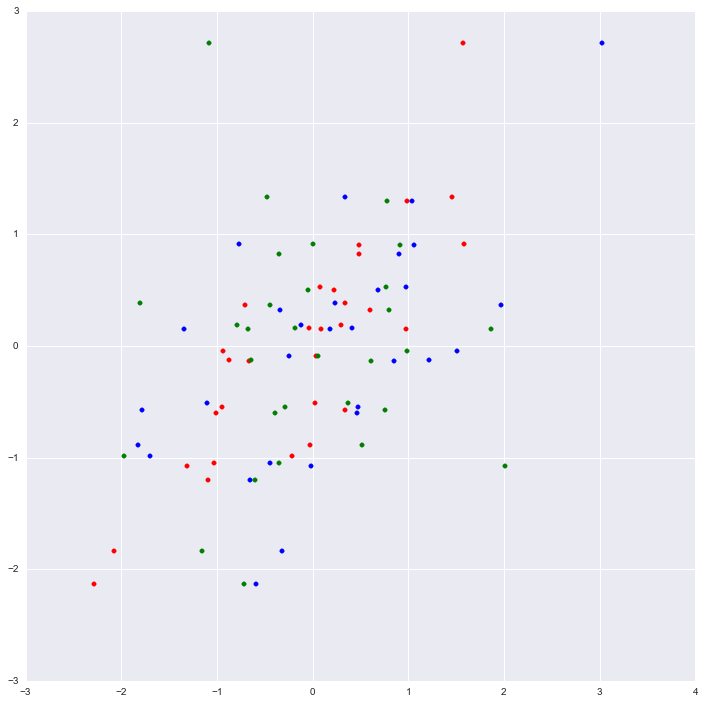

In [547]:
#X COLUMNS VS Y
plt.scatter(test_x[:,0],test_y,color='r')
plt.scatter(test_x[:,1],test_y,color='g')
plt.scatter(test_x[:,2],test_y,color='b')
plt.show()

---

## 2_PROVIDE INITIAL OBJECTS:

In [107]:
step_num = 1
increment = .004
length = train_x.shape[0]
cols = train_x.shape[1]
beta_matrix = []
beta_list = [0]*cols
beta_matrix.append(beta_list)

print('steps',step_num)
print('incement',increment)
print('length',length)
print('cols',cols)
print('beta_list',beta_list)
print('beta_matrix',beta_matrix)

('steps', 1)
('incement', 0.004)
('length', 70)
('cols', 3)
('beta_list', [0, 0, 0])
('beta_matrix', [[0, 0, 0]])


## 3:8_ALGORITHM DETAILS

#### THE BETA MATRIX:   
<b>
* The LARS algorithm outputs a beta matrix.    
* The beta matrix is a list holding other lists.     
* The other lists are filled with the beta combinations evaluated at each step.    
* The first entry in the beta matrix has all betas set to zero.
</b>

<b>
EXECUTION STRATEGY:    
The function is split up into two sections:   
* CORE FUNCTIONS: Separate functions for calculating residuals, correlations, and increments.   
* CONTROL STRUCTURE: Glues the core functions together into a loop that is run a set number of times.    
</b>

<b>
CORE FUNCTIONS 
For calculating residuals, correlations, and increments.
</b>

<b>
* RESIDUALS: Find the error term (called a residual) per row. 
    + It is calculated as the difference between the actual y_value for the row AND the sum of each term in the row multiplied by its beta value.     
</b>

<b>
* CORRELATIONS: Find the correlations per column given the rows and their residuals
    + In each column:
    + Multiply each row value by the row’s residual,
    + Sum the total and divide by the total number of rows in the column. 
    + This will create a single correlation value per column  
</b>

<b>
* INCREMENT: Find the most correlated beta, increment it, and add the results to the beta matrix. 
    + Find the column with the largest correlation.
    + Add or subtract the step-sized step from it. (Add if correlation is positive, subtract if negative)
    + Take the latest entry in the beta matrix, and replace the un-incremented term with the incremented term to create an updated list of betas. Add this updated list as the next entry in the beta matrix. 

</b>

<b>
CONTROL STRUCTURE:
The functions are chained together into a loop that adds an entry into the beta matrix each time it runs.
* In this loop, Inputs are fed into residuals, which are fed into correlations, which are fed into the increment. 
* The loop runs a set number of times. 
* The result after the loop completes is a beta matrix of coefficients. 
* The beta matrix can the be operated on…
</b>
   

In [419]:
def beta_matrix(x_data,y_data,step_num,increment):

#CORE FUNCTIONS====------------------------------------------------------
    
    #RESIDUALS-----------------------------------------------------------
    def residuals(x_data,y_data,beta_list):  
        rows = x_data.shape[0]
        cols = x_data.shape[1]
        residuals = []
        for r in range(rows):
            terms = []
            for c in range(cols):
                term = x_data[r,c] * beta_list[c]
                terms.append(term)
            residual = y_data[r] - sum(terms)
            residuals.append(residual)
        return residuals 
    
    #CORRELATIONS--------------------------------------------------------
    def correlations(x_data,y_data,res):

        rows = x_data.shape[0]
        cols = x_data.shape[1]

        corr = []

        for c in range(cols):
            x_res = []
            for r in range(rows):
                x_res.append(train_x[r][c] * res[r])
            corr.append(sum(x_res)/rows)
        return corr

    #INCREMENT----------------------------------------------------------
    def increment_beta(cor,increment):
  
        #LARGEST CORRELATION
        best_cor_ix = 0
        best_cor = cor[0]
        
        for r in range(1, (cols)):
            if abs(best_cor) < abs(cor[r]):
                best_cor_ix = r; best_cor = cor[r]
        
        beta_list[best_cor_ix] += increment * (best_cor / abs(best_cor))
        beta_matrix.append(list(beta_list))

#CONTROL STRUCTURE-------------------------------------------------

    #DATA SHAPE
    length = train_x.shape[0]
    cols = train_x.shape[1]
    
    #ASSETS
    beta_matrix = []
    beta_list = [0]*cols
    beta_matrix.append(beta_list) 
    
    #CONTROL FLOW
    for r in range(step_num):
        res = residuals(train_x,train_y,beta_list)
        cor = correlations(train_x,train_y,residuals(train_x,train_y,beta_list))
        increment_beta(cor,increment)
    return beta_matrix[1:]

#OUTPUT
beta_matrix(train_x,train_y,350,.004)[:10]

[[0.0040000000000000001, 0, 0],
 [0.0080000000000000002, 0, 0],
 [0.012, 0, 0],
 [0.016, 0, 0],
 [0.02, 0, 0],
 [0.024, 0, 0],
 [0.028000000000000001, 0, 0],
 [0.032000000000000001, 0, 0],
 [0.036000000000000004, 0, 0],
 [0.040000000000000008, 0, 0]]

---

## 9:10_EVALUATE, PRODUCE, PREDICT

> ### Lets visualize this output:

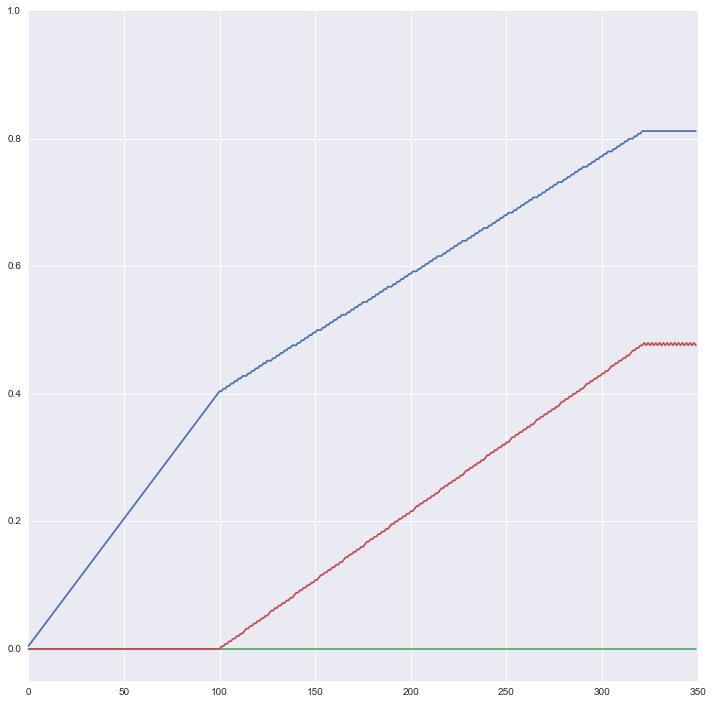

In [546]:
lars_train_1 = beta_matrix(train_x,train_y,350,.004)

def see_coef_matrix(matrix):
    cols = len(matrix[0])
    rows = len(matrix)
    
    for x in range(cols):
        value_list = [matrix[y][x] for y in range(rows)]
        value_space = [x for x in range(len(value_list))]
        plt.plot(value_space,value_list)

plt.ylim(-.05,1)
see_coef_matrix(lars_train_1)

>> ### At a later step in the algorithm, the betas seem to level off. Note that e green betas remain at zero due to their low level of correlation. This effectively takes the green feature and eliminates it from the prediction model. 


---

> ### LETS DETERMINE THE ERROR OF EACH BETA LIST IN THE MATRIX

In [583]:
#for each row of coefficients: 
#calculate mean squred error of its predictions against the actual outcomes

def mse_path(model,train_x,train_y,):
    
    mse_path = []
        
    length = train_x.shape[0]
    cols = train_x.shape[1]

    
    for coefs in model:
    
        predictions = []

        for y in range(length):
            coef_vals = []
            for z in range(cols):
                coef_val = coefs[z] * train_x[y][z]
                coef_vals.append(coef_val)
            predictions.append(sum(coef_vals))
        
        squared_errors = [(predictions[x]-train_y[x])**2 for x in range(length)]
        mse_path.append([coefs,sum(squared_errors)/length])
        
    return (mse_path)

mse_path(model,train_x,train_y,)[:10]
                       #[coefs],[mse]

[[[0.0040000000000000001, 0, 0], 1.0084161157948592],
 [[0.0080000000000000002, 0, 0], 1.001145379400104],
 [[0.012, 0, 0], 0.99390740444296399],
 [[0.016, 0, 0], 0.98670219092343814],
 [[0.02, 0, 0], 0.97952973884152805],
 [[0.024, 0, 0], 0.97239004819723263],
 [[0.028000000000000001, 0, 0], 0.96528311899055186],
 [[0.032000000000000001, 0, 0], 0.95820895122148642],
 [[0.036000000000000004, 0, 0], 0.95116754489003585],
 [[0.040000000000000008, 0, 0], 0.94415889999619951]]

> ### LETS SEE HOW THE ERRORS EVOLVE WITH EACH INCREMENT:

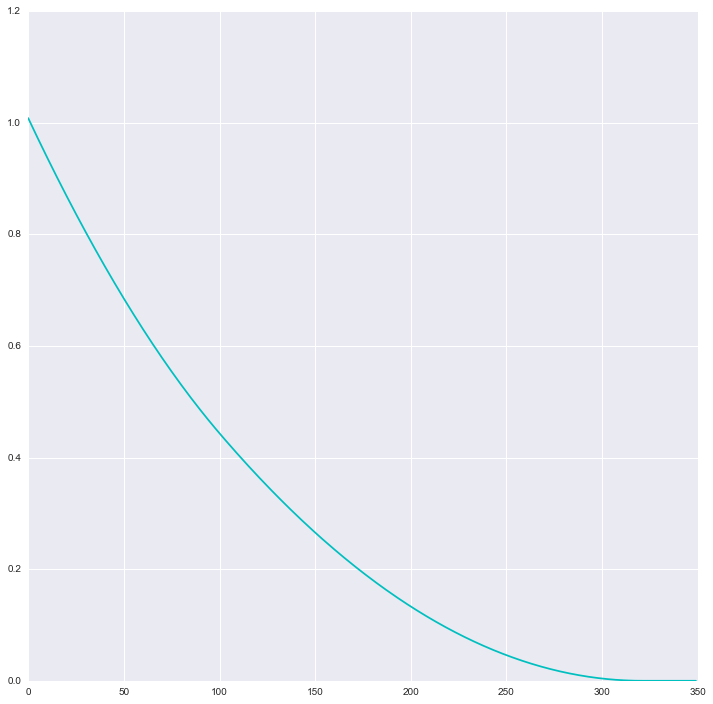

In [544]:
model = beta_matrix(train_x,train_y,350,.004)
mse = mse_path(model,train_x,train_y,)

err = [x[1] for x in mse]
plt.plot(range(len(err)),err,color='c')
plt.show()

> ### LETS SEARCH FOR THE COEFS WITH THE LOWEST ERROR:

In [529]:
mse = mse_path(model,train_x,train_y,)

def best_fit(mse):
    sorted_mse = sorted(mse, key = lambda x: x[1])
    best_coefs = [x[0] for x in sorted_mse][0]
    index = []
    index=min([x for x,y in enumerate(mse) if y[0] == best_coefs])
    return [index,best_coefs]
    #returns best step where best coefs first appears, and the coefs themselves

best_fit(mse)

[321, [0.81200000000000061, 0, 0.47600000000000037]]

>> #### It is found at step 321 of the error path.

> ### COMPARE AGAINST LARS SKLEARN IMPLEMENTATION:

In [491]:
from sklearn.linear_model import Lars
lars = Lars(n_nonzero_coefs=3,normalize=False)
lars.fit(train_x,train_y)
lars.get_params

<bound method Lars.get_params of Lars(copy_X=True, eps=2.2204460492503131e-16, fit_intercept=True,
   fit_path=True, n_nonzero_coefs=3, normalize=False, positive=False,
   precompute='auto', verbose=False)>

In [492]:
lars.coef_

array([ 0.811,  0.   ,  0.477])

>>### An almost exact match to sklearn! 

>### Lets visualize how the error relates to the coefficients:

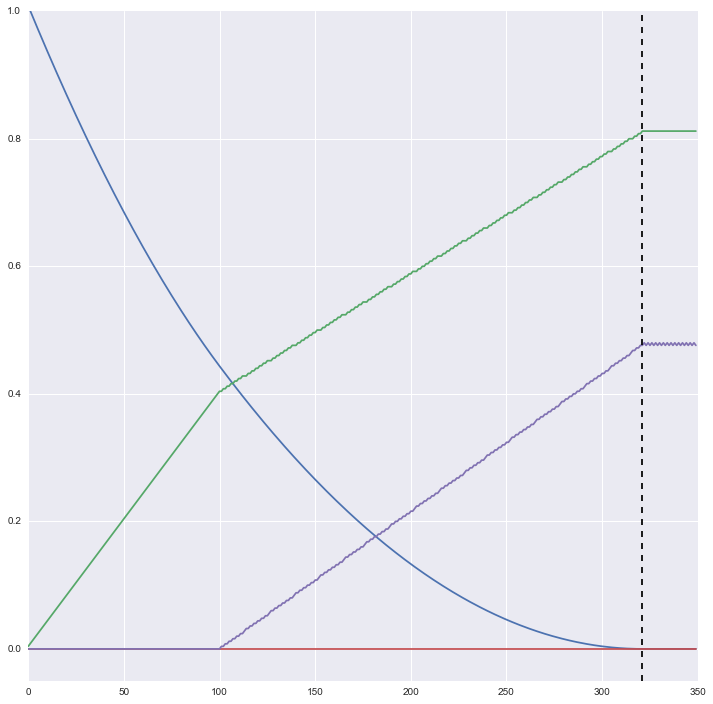

In [543]:
model = beta_matrix(train_x,train_y,350,.004)

mse = mse_path(model,train_x,train_y,)
err = [x[1] for x in mse]
plt.plot(range(len(err)),err)

see_coef_matrix(model)

plt.rcParams['figure.figsize']=(12,12)

plt.axvline(best_fit(mse)[0],c='k',ls='dashed')
plt.ylim(-.05,1)

plt.show()

><b>The error declines as the coefficients increase. Both the error and the coefficients stabilize at step 321 where we have the optimum coef values of [0.812, 0, 0.477]


---

> ### PREDICTION:

>><b> Remember our data was already split and we withheld a test-set at the start...

In [615]:
test_x

array([[-0.874804105 , -0.641476066 ,  1.2181214931],
       [ 0.4871853163, -0.3550151822,  0.9032879444],
       [-1.0986017921, -0.6052054407, -0.6538986249],
       [-0.2128719459, -1.9745748654, -1.6978229797],
       [ 0.3359766639, -1.8061009823,  0.234395534 ],
       [ 0.2987677667, -0.7934662678, -0.1214294967],
       [ 0.0833561237, -0.6794034708,  0.1761130029],
       [ 0.4857315022,  0.9098342239,  1.0627202843],
       [ 0.9779386047,  1.8638612682, -1.3467062144],
       [-0.6699960566,  0.6090378756,  0.8538346212],
       [ 1.4522260811, -0.4795411033,  0.3380078606],
       [ 0.2192480916, -0.0507120784,  0.6778814793],
       [ 0.0733462077,  0.7639117389,  0.9737006196],
       [-0.0372876314, -0.1822075245,  0.4106436167],
       [ 0.5955162489,  0.7990205945, -0.3448059594],
       [-0.9385427184,  0.9889996655,  1.5079736376],
       [-1.0146794302, -0.3903718585,  0.4598670445],
       [ 0.03505488  ,  0.057347842 , -0.2459694883],
       [-2.2807894637, -0.72

In [617]:
for x in test_y[:10]:print(x)

-0.128297349993
0.826367483183
-1.20335588757
-0.983052036038
0.384440636578
0.184422086631
0.151681051533
0.90128378806
0.150594183389
-0.136015158293


In [567]:
betas

[0.81200000000000061, 0, 0.47600000000000037]

In [596]:
def predict(betas,test_x,test_y):
    
    length = test_x.shape[0]
    cols = test_x.shape[1]
    
    predictions = []
    
    for x in range(length):
        beta_vals = []
        for y in range(cols):
            beta = betas[y] * test_x[x][y]
            beta_vals.append(beta)
        predictions.append(sum(beta_vals))
    
    return predictions
    
betas = best_fit(mse)[1]  
pred = predict(betas,test_x,test_y)
pred[:10]

[-0.13051510256702148,
 0.82555953837278317,
 -1.2033204006369891,
 -0.98101575838183785,
 0.38438532528451502,
 0.18479898615297274,
 0.15151496180213059,
 0.90026883509885525,
 0.15305398893385469,
 -0.13761151830536611]

> ### LETS CALCULATE THE ERROR OF OUR PREDICTIONS ON THE FINAL DATA:

In [612]:
from sklearn.metrics import mean_squared_error
mserr = mean_squared_error(pred, test_y)
print(['mse:',mserr],['rmse:',math.sqrt(mserr)])

(['mse:', 2.422813493917039e-06], ['rmse:', 0.0015565389471250113])


>> ### Very low error! Lets visualize how our predictions look VS actual targets:

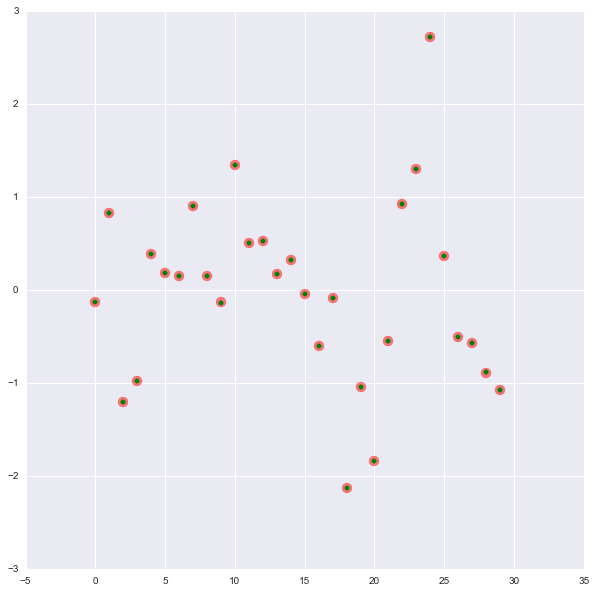

In [618]:
plt.scatter(range(len(pred)),test_y,color='r',alpha=.5,s=100)
plt.scatter(range(len(pred)),pred,color='g')
plt.rcParams['figure.figsize']=(10,10)

> ### Awww Yissssss! Our predictions are so accurate that the red (actual) and green (predicted) values overlap. At step 321 of the LARS algorithm execution, we discovered the function that produced the data! 

<i>(Real world data is usually much much messier)

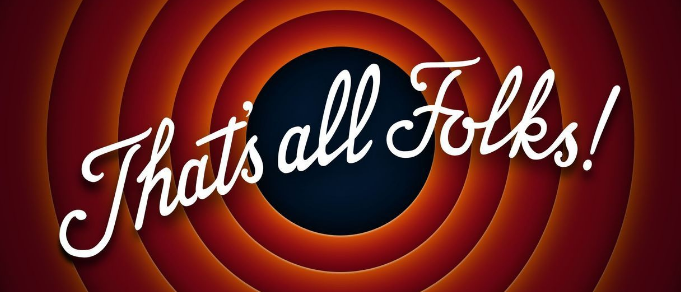

In [628]:
from IPython.display import Image
Image(filename='TAF.png')